# Geometric Positioning of InSAR Points

@author: Max Felius

## Hypothesis
The retrieval of sinkhole parameters can be improved by a better spreading of the measurement points.
- A better spreading of points will lead to a lower conditional number of the design matrix.
- A better spreading will lead to a higher fitting percentage and a lower RMSE.

## Predictions (better articulate this part...)
- Higher fit will be accompanied with a lower conditional number.
- Less points will provide a worse fit.
- Points on a line or spread out on a 2D plane won't affect the fit and conditional number.
- The further the points away from the center, the worse the fit will be.
- Very heterogenous points will provide a worse fit
- The more points with the same radius will give worse fit

## Design the experiment
- Define sinkhole using kinematic model
- Define inverse model to retrieve parameters
- Define tool to create point samples
- Generate seperate cases for each prediction and answer that prediction

In [31]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
#kinematic model
def zg(R,r):
    return (1/(R*R))*np.exp(-np.pi*(r**2/R**2))

In [3]:
#defining the inverse model
def inverse_kinematic_model(v,t,R,r,y):
    '''
    Non-Linear Least Squares for determining kinematic model parameters
    
    Input:
    :type v: int
    :type t: np.array(float)
    :type R: int
    :type r: np.array(float)
    :type y: np.array(float)
    
    Output
    :rtype R: int
    :rtype v: int
    '''
    #maximum number of runs
    n = 10000
    
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    #start the timer
    start = time.time()
    
    for i in range(n):
        #expected deformation
        yhat = v*t*zg(R,r)
        
        #compute the difference in measured and computed subsidence
        dy = y - yhat
        
        #defining the jacobian matrix
        A1 = t*zg(R,r,itype)
        A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
           
        J = np.array([A1,A2]).T
        
        Qxhat = np.linalg.inv(J.T @ invQyy @ J)
        dx = Qxhat @ J.T @ invQyy @ dy
        
        v_old = v
        R_old = R
        v = v + dx[0]
        R = R + dx[1]
        
        dx_hat = np.array([v_old-v,R_old-R]).T
        
        if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
            print(f'Stopped at iteration {i+1}.\nThe computed values are v={v} and R={R}.')
            break
    
    if i == n-1:
        print(f'Ended using the maximum number of iterations: {n}.\nThe computed values are v={v} and R={R}.')
    
    print(f'The total runtime was: {time.time()-start} seconds.')
    
    return v, R

In [33]:
#Create tool to make point samples
#using the sinkhole from wink2016 for generating the point samples
v_wink2016_gaus = 95.78920335026163
R_wink2016_gaus = 553.0609564207195
t = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#coordinates
x0 = 25
y0 = 25

#More sinkhole parameters
n = 1000
x_range = 1000
y_range = 1000

x = np.linspace(x0-x_range/2,x0+x_range/2,n)
y = np.linspace(y0-y_range/2,y0+y_range/2,n)

xv, yv = np.meshgrid(x,y)

r = np.sqrt((xv-x0)**2 + (yv-y0)**2)

z = zg(R_wink2016_gaus,r)

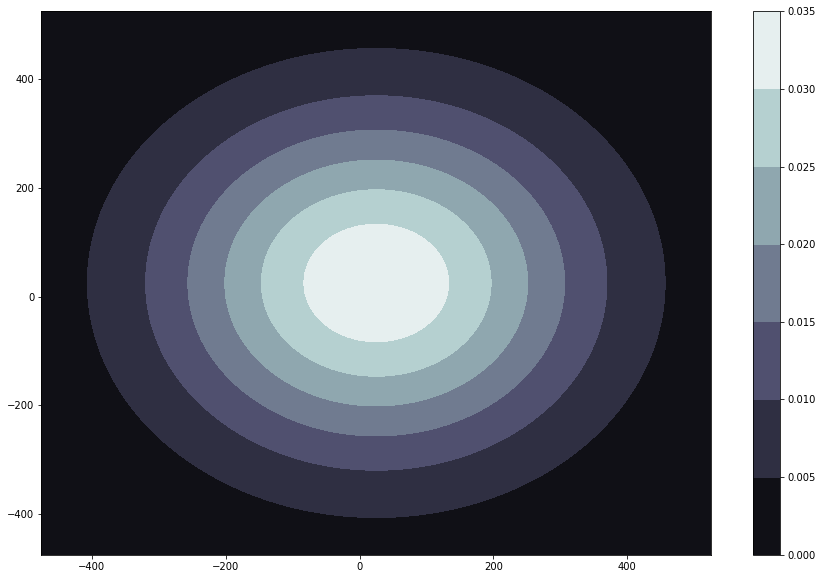

In [28]:
#plot the sinkhole
fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(15,10))
i = 8
h = axs.contourf(x,y,t[i]*v_wink2016_gaus*z,cmap=plt.cm.bone,origin='lower')
fig.colorbar(h);

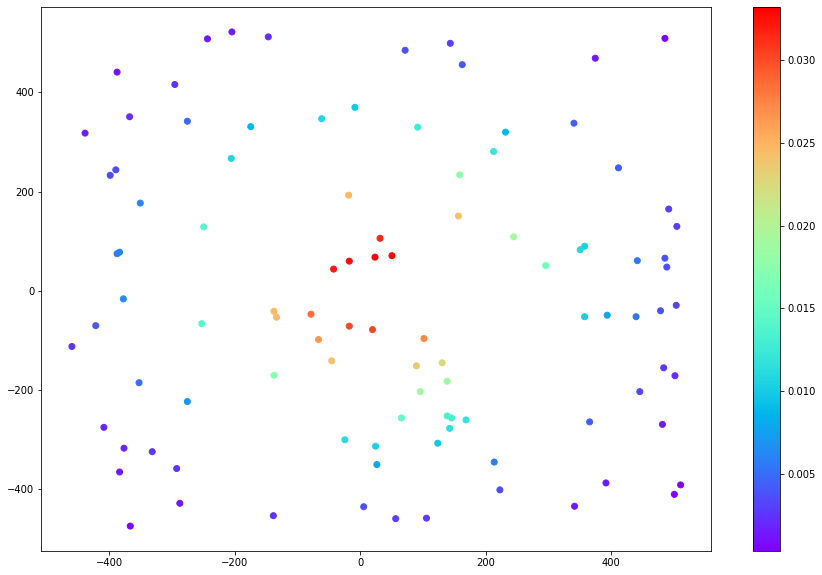

In [56]:
z_eval = (t[i]*v_wink2016_gaus*z).ravel()

#test monte carlo method for extracting random points
n_sub = 0.0001*n*n
idx = random.sample(range(0,len(z_eval)),int(n_sub))

z1 = z_eval[idx]
x1 = xv.ravel()[idx]
y1 = yv.ravel()[idx]
# z_eval = z_eval.reshape((x_range,y_range))


fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(15,10))
i = 8
h = axs.scatter(x1,y1,c=z1,cmap=plt.cm.rainbow)
fig.colorbar(h);
